# Ejercicio Data Science Quilmes

## Importancion de librerias

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy 
import pandas as pd
import seaborn

## Importancion de datasets

In [5]:
df_blacklist = pd.read_csv('Datos/blacklist.csv',sep=',')
print(f'Blacklist tiene {len(df_blacklist)} filas')
df_segmentacion =  pd.read_csv('Datos/channel_segmentation.csv',sep=',')
print(f'Channel_segmentation tiene {len(df_segmentacion)} filas')
df_client =  pd.read_csv('Datos/clients.csv',sep=',')
print(f'Clients tiene {len(df_client)} filas')
df_coupons =  pd.read_csv('Datos/coupons.csv',sep=',')
print(f'Coupons tiene {len(df_coupons)} filas')
df_sales1 =  pd.read_csv('Datos/sales_2022_sementre_1.csv',sep=',')
print(f'Sales_2022_sementre_1 tiene {len(df_sales1)} filas')
df_sales2 =  pd.read_csv('Datos/sales_2022_semestre_2.csv',sep=',')
print(f'Sales_2022_sementre_2 tiene {len(df_sales2)} filas')
df_sales3 =  pd.read_csv('Datos/sales_2023_semestre_1.csv',sep=',')
print(f'Sales_2023_semestre_1 tiene {len(df_sales3)} filas')

Blacklist tiene 5937 filas
Channel_segmentation tiene 38 filas
Clients tiene 49458 filas
Coupons tiene 805757 filas
Sales_2022_sementre_1 tiene 588683 filas
Sales_2022_sementre_2 tiene 613864 filas
Sales_2023_semestre_1 tiene 571918 filas


In [6]:
df_blacklist.head(3)

,cliente_id
0,2076569343
1,486609981
2,-2133238226


In [7]:
df_segmentacion.head(3)

,channel_id,channel_segmentation
0,565501238,NO
1,1377949257,NO
2,1059805429,OTROS


In [8]:
df_segmentacion.channel_segmentation.unique()

array(['NO', 'OTROS', 'RESTAURANTE', 'PUB', 'TRADICIONAL', 'SMK',
       'AUTOSERVICIOS', 'KIOSCOS', 'INSTITUCIONES', 'MAYORISTA'],
      dtype=object)

In [9]:
df_client.head(3)

,cliente_id,channel_id,region
0,-1726485189,1759010777,COSTA ATLANTICA
1,-928788236,1625004744,GBA MINORISTAS
2,1641917107,1625004744,COSTA ATLANTICA


In [10]:
df_coupons.head(3)

,cliente_id,business,brand,yearmonth,sales_with_coupons
0,-1133775360,CZA,brahma_dorada,202307,53
1,-2013629997,CZA,andes,202304,483
2,-1623564940,CZA,quilmes,202310,41


## Preparado de los datos

### Tipo de datos

In [13]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49458 entries, 0 to 49457
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cliente_id  49458 non-null  int64 
 1   channel_id  49458 non-null  int64 
 2   region      49458 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


Es correcto que las columnas cliente_id y channel_id sean datos de tipo entero? Al realizar analisis de las mismas, como que tipo de datos deberiamos tratarlas? 

Chequear para los otros dataset y convertir los tipos de datos de ser necesario. 

### Duplicados

In [16]:
df_client.shape

(49458, 3)

Observo cuantos clientes estan presentes en mas de un canal/region.

In [18]:
df_client.groupby('cliente_id').count().sort_values(by='channel_id',ascending=False).head(10)

,channel_id,region
cliente_id,,
-723357213,2,2
-1834569221,2,2
1167709665,2,2
481102357,2,2
1913960401,2,2
714444859,1,1
713495976,1,1
712809958,1,1
713007622,1,1


In [19]:
df_client[df_client['cliente_id'] == -723357213]

,cliente_id,channel_id,region
7638,-723357213,1625004744,LITORAL
49455,-723357213,1625004744,LITORAL


Detecto que existen duplicados por lo cual, elimino los clientes duplicados del dataset de clientes. 

In [21]:
df_client = df_client.drop_duplicates().reset_index().drop(columns='index')
df_client.shape

(49454, 3)

In [22]:
df_client.groupby('cliente_id').count().sort_values(by='channel_id',ascending=False).head(10)

,channel_id,region
cliente_id,,
481102357,2,2
-2147472583,1,1
713495976,1,1
712728574,1,1
712809958,1,1
713007622,1,1
713163764,1,1
713176352,1,1
713228378,1,1


Existe un unico cliente que esta presente en dos canales y regiones. 

In [24]:
df_client[df_client['cliente_id'] == 481102357]

,cliente_id,channel_id,region
13138,481102357,651275377,GBA MINORISTAS
26907,481102357,1625004744,LITORAL


### Concatenacion y/o mergeo de los datos

In [26]:
df_client.shape

(49454, 3)

1. Del dataset de clientes quitamos los clientes que estan presentes en la blacklist del analisis

In [28]:
blacklist = list(df_blacklist.cliente_id.unique())

In [29]:
df_client = df_client[~df_client['cliente_id'].isin(blacklist)]
df_client.shape

(48414, 3)

2. Del dataset de clientes quitamos los canales-segmentos que no nos interesan del analisis.

In [31]:
#Los segmentos a considerar para el calculo del lift
df_segmentacion[df_segmentacion['channel_segmentation'].isin(['AUTOSERVICIOS', 'KIOSCOS' , 'TRADICIONAL'])] 

,channel_id,channel_segmentation
7,1625004744,TRADICIONAL
14,651275377,AUTOSERVICIOS
17,651275377,KIOSCOS
20,-1756013582,AUTOSERVICIOS
35,-866616713,KIOSCOS
37,870267989,KIOSCOS


In [32]:
channel_list = list(df_segmentacion[df_segmentacion['channel_segmentation'].isin(['AUTOSERVICIOS', 'KIOSCOS' , 'TRADICIONAL'])].channel_id.unique())

In [33]:
channel_list

[1625004744, 651275377, -1756013582, -866616713, 870267989]

In [34]:
df_client = df_client[df_client['channel_id'].isin(channel_list)]
df_client.shape

(35618, 3)

In [35]:
df_client.groupby('cliente_id').channel_id.count().sort_values().tail(10)

cliente_id
-715870445     1
-716308667     1
-716165947     1
-716156829     1
-716149560     1
-716083054     1
-716026542     1
-716266132     1
 2147118616    1
 481102357     2
Name: channel_id, dtype: int64

3. Concatemos los 3 datasets de ventas

In [37]:
df_ventas_tot = pd.concat([df_sales1,df_sales2,df_sales3]) #con axis podemos indicar si queremos concatenar por filas o columnas
df_ventas_tot.shape

(1774465, 5)

In [38]:
df_ventas_tot.tail()

,cliente_id,business,brand,sales,yearmonth
571913,1570019169,CZA,corona,89.91888,202301
571914,1958127344,CZA,otras,0.00000,202301
571915,36538050,CZA,otras,0.00000,202302
571916,-1789403340,CZA,otras,0.00000,202301
571917,772148154,CZA,patagonia,11.80800,202305


4. Mergeamos datasets de ventas con dataset de clientes. 

Como hacer un mergeo o join de datos? Debemos indicar en how que tipo de join queremos hacer, y en on cual va a ser la clave para realizarlo. 

Tambien podemos hacer un merge considerando varias columnas como claves.

In [42]:
pd.merge(df_client,df_ventas_tot[['cliente_id','sales','yearmonth']],how='inner',
         on='cliente_id')

,cliente_id,channel_id,region,sales,yearmonth
0,-928788236,1625004744,GBA MINORISTAS,0.17040,202203
1,-928788236,1625004744,GBA MINORISTAS,0.14190,202204
2,-928788236,1625004744,GBA MINORISTAS,0.20514,202204
3,-928788236,1625004744,GBA MINORISTAS,0.11352,202201
4,-928788236,1625004744,GBA MINORISTAS,0.05676,202202
...,...,...,...,...,...
1246462,-144622375,651275377,GBA MINORISTAS,0.28380,202302
1246463,-144622375,651275377,GBA MINORISTAS,0.79464,202304
1246464,-144622375,651275377,GBA MINORISTAS,0.56760,202302
1246465,-144622375,651275377,GBA MINORISTAS,0.34056,202306


In [43]:
df_ventas_total = pd.merge(df_client,df_ventas_tot,how='inner',
         on='cliente_id')

In [44]:
df_ventas_total.drop(columns='business',inplace=True)

In [45]:
df_coupons.drop(columns='business',inplace=True)

5. Mergeamos datasets de ventas con dataset de copunes. 

In [47]:
df_coupons.head(3)

,cliente_id,brand,yearmonth,sales_with_coupons
0,-1133775360,brahma_dorada,202307,53
1,-2013629997,andes,202304,483
2,-1623564940,quilmes,202310,41


In [48]:
df_ventas_tot.head(3)

,cliente_id,business,brand,sales,yearmonth
0,1690894282,CZA,quilmes,1.81962,202201
1,-985525432,CZA,brahma,0.73548,202201
2,-674489716,CZA,brahma,4.55328,202201


In [49]:
df_ventas_totales = pd.merge(df_ventas_total, df_coupons, on=['cliente_id','brand','yearmonth'], how='left')

Vamos a agregar una columna que nos indique en que caso las ventas seran consideradas para el analisis de mkt, teniendo en cuenta que si la columna sales_with_coupons supera 5 sera considerada como parte de la campaña. 

In [51]:
df_ventas_totales['participation_campein'] = df_ventas_totales['sales_with_coupons'].apply(lambda x: 'Si' if x>5 else 'No')

In [52]:
df_ventas_totales[['sales_with_coupons','participation_campein']].sample(5)

,sales_with_coupons,participation_campein
645525,NaN,No
52834,NaN,No
649714,NaN,No
1194740,NaN,No
423131,NaN,No


In [53]:
df_ventas_totales.shape

(1246467, 8)

In [54]:
df_ventas_totales.isna().sum()

cliente_id                     0
channel_id                     0
region                         0
brand                          0
sales                          0
yearmonth                      0
sales_with_coupons       1188327
participation_campein          0
dtype: int64

6. Filtramos aquellos periodos de tiempo que nos van a interesar en el analisis

In [56]:
df_ventas_totales = df_ventas_totales[(df_ventas_totales['yearmonth'] > 202112) &
                        (df_ventas_totales['yearmonth'] < 202307)]

In [57]:
df_ventas_totales.cliente_id.nunique()

28220

## Analisis de los datos

Describes, groupby y diferentes graficos pueden ser utiles para observar el comportamiento de los datos.

### Sales_with_coupons 

In [61]:
df_ventas_totales['sales_with_coupons'].describe()

count    58140.000000
mean        13.678896
std         45.223249
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       1961.000000
Name: sales_with_coupons, dtype: float64

In [70]:
df_ventas_totales['sales_with_coupons'].quantile(0.995)

260.9150000000009

In [72]:
df_coupons.groupby(['yearmonth','brand'])['sales_with_coupons'].sum()

yearmonth  brand        
202109     quilmes            3548
202110     brahma                2
           quilmes           13481
202111     brahma             9012
           quilmes            1685
                             ...  
202310     michelob           7620
           patagonia         13345
           quilmes          111625
           stella_artois     46843
           temple             5943
Name: sales_with_coupons, Length: 210, dtype: int64

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


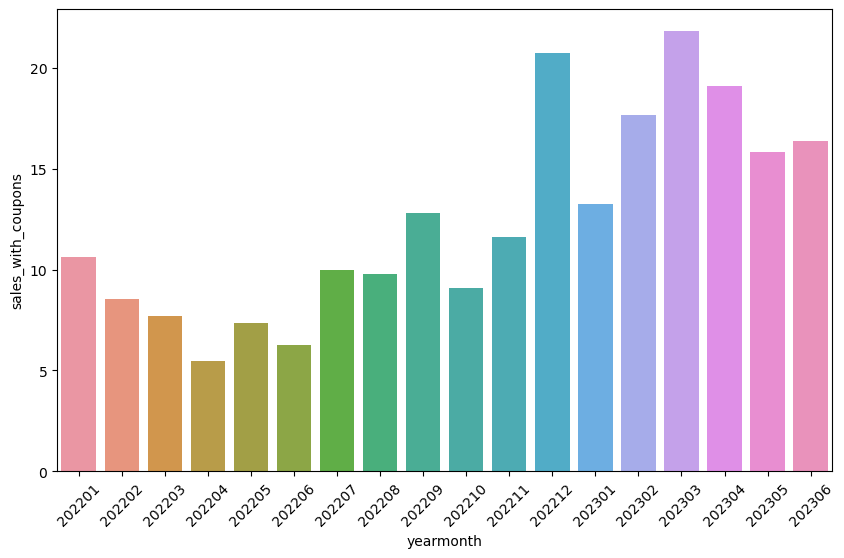

In [74]:
fig = plt.figure(figsize=(10,6))
seaborn.barplot(data=df_ventas_totales,
                y='sales_with_coupons', x='yearmonth',
                estimator=numpy.mean)
plt.xticks(rotation=45)
plt.show()

Podemos observar como cambia la distrucion de la columna sales_with_coupons en funcion a si el cliente participo o no en la campaña.

In [76]:
df_ventas_totales[~df_ventas_totales['sales_with_coupons'].isna()]['participation_campein'].value_counts()

participation_campein
No    39408
Si    18732
Name: count, dtype: int64

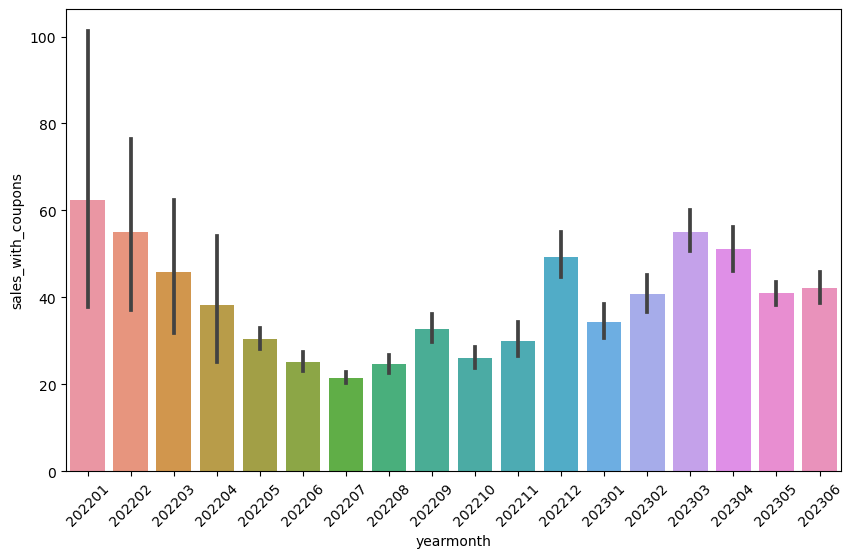

In [77]:
fig = plt.figure(figsize=(10,6))
seaborn.barplot(data=df_ventas_totales[df_ventas_totales['participation_campein'] == 'Si'],
                y='sales_with_coupons', x='yearmonth',
                estimator=numpy.mean)
plt.xticks(rotation=45)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


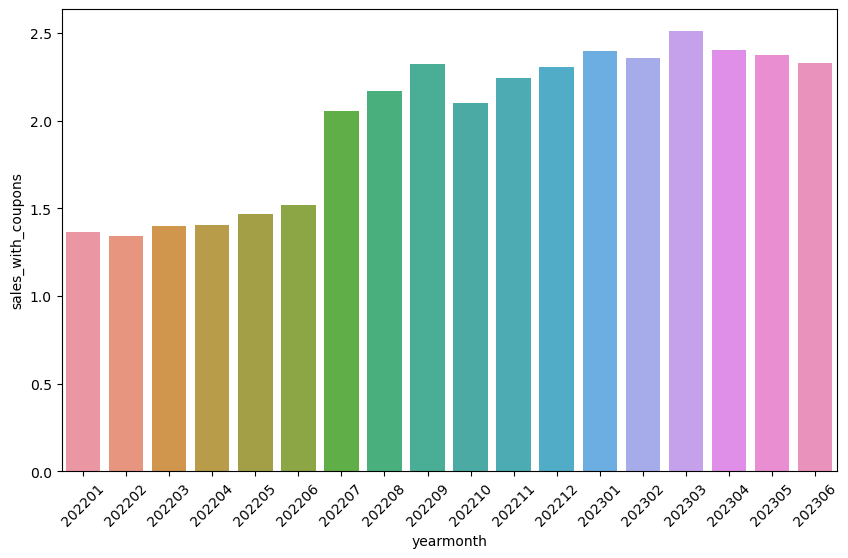

In [78]:
fig = plt.figure(figsize=(10,6))
seaborn.barplot(data=df_ventas_totales[df_ventas_totales['participation_campein'] == 'No'],
                y='sales_with_coupons', x='yearmonth',
                estimator=numpy.mean)
plt.xticks(rotation=45)
plt.show()

In [79]:
df_ventas_totales.groupby(['yearmonth','participation_campein'])['cliente_id'].nunique()

yearmonth  participation_campein
202201     No                       19254
           Si                          93
202202     No                       18894
           Si                         100
202203     No                       19389
           Si                          73
202204     No                       18877
           Si                          67
202205     No                       18842
           Si                         363
202206     No                       19213
           Si                         416
202207     No                       19264
           Si                         758
202208     No                       20315
           Si                         469
202209     No                       20845
           Si                         540
202210     No                       20427
           Si                         389
202211     No                       21312
           Si                         501
202212     No                       21084
 

In [95]:
df_ventas_totales[~df_ventas_totales['sales_with_coupons'].isna()]['yearmonth'].value_counts()

yearmonth
202305    5274
202303    5135
202304    4871
202206    4652
202205    4521
202306    4214
202207    4096
202302    3634
202212    3425
202209    3369
202301    3188
202210    3049
202208    3031
202211    2973
202202     804
202204     718
202201     614
202203     572
Name: count, dtype: int64

Con el boxplot podemos observar la distribucion que asume una determinada variable, y tambien compararla.

<Axes: xlabel='sales_with_coupons'>

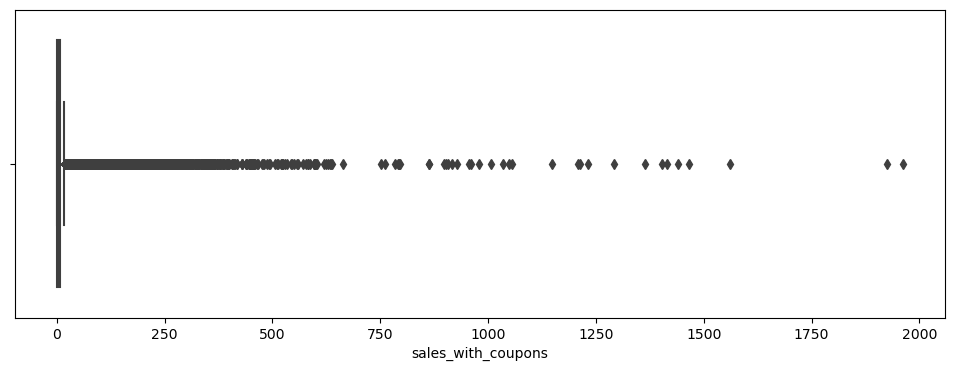

In [98]:
plt.figure(figsize=(12, 4))
seaborn.boxplot(x=df_ventas_totales['sales_with_coupons'])

In [100]:
limit = df_ventas_totales['sales_with_coupons'].quantile(0.95)
limit

59.0

<Axes: xlabel='sales_with_coupons'>

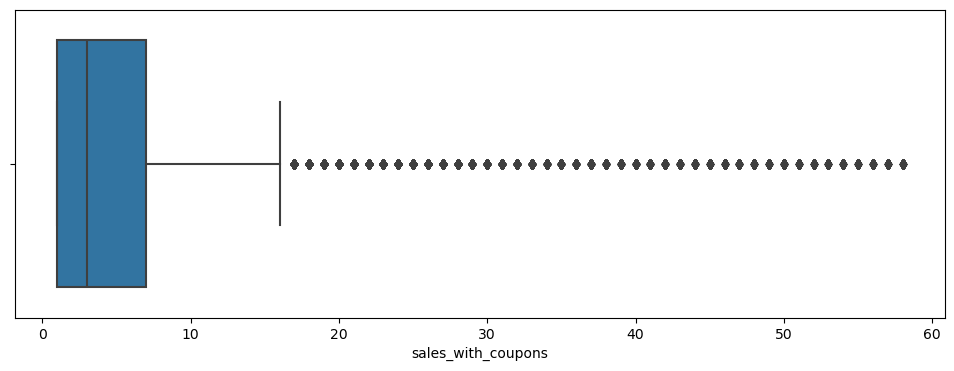

In [102]:
plt.figure(figsize=(12, 4))

seaborn.boxplot(x=df_ventas_totales[df_ventas_totales['sales_with_coupons'] < limit]['sales_with_coupons'])

<Axes: xlabel='sales_with_coupons'>

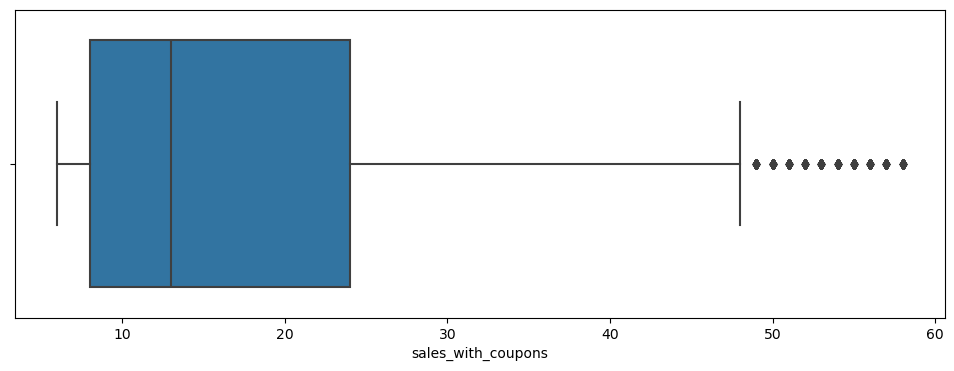

In [104]:
plt.figure(figsize=(12, 4))

seaborn.boxplot(x=df_ventas_totales[(df_ventas_totales['sales_with_coupons'] < limit) &
                                  (df_ventas_totales['participation_campein'] == 'Si') 
                                 ]['sales_with_coupons'])

<Axes: xlabel='sales_with_coupons'>

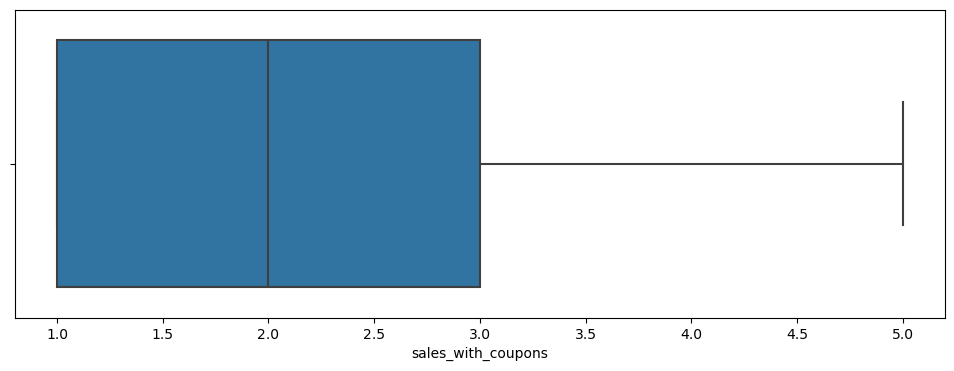

In [109]:
plt.figure(figsize=(12, 4))

seaborn.boxplot(x=df_ventas_totales[(df_ventas_totales['sales_with_coupons'] < limit) &
                                  (df_ventas_totales['participation_campein'] == 'No') 
                                 ]['sales_with_coupons'])

### Sales

In [112]:
df_ventas_totales.groupby('region')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
CENTRAL,218562.0,0.706065,3.958418,-1.66680,0.08520,0.233520,0.56760,652.75056
COSTA ATLANTICA,56624.0,2.026900,17.666121,-1.58928,0.11700,0.268380,0.72000,1843.08984
GBA MINORISTAS,300049.0,2.314099,24.831536,-18.00000,0.11352,0.347520,1.04760,2769.76584
LITORAL,401672.0,1.260227,7.242561,-2.04004,0.09840,0.261900,0.84000,1808.48712
NEA,73282.0,1.360494,10.816718,-0.91762,0.11700,0.299365,0.85200,794.29944
NOA,96293.0,1.634018,20.103528,-5.58444,0.08520,0.227040,0.60000,2269.96341
PATAGONIA,99985.0,1.910964,8.591776,-1.46460,0.12000,0.350400,1.14384,543.28560


Con el countplot se visualiza la frecuencia de los datos. 

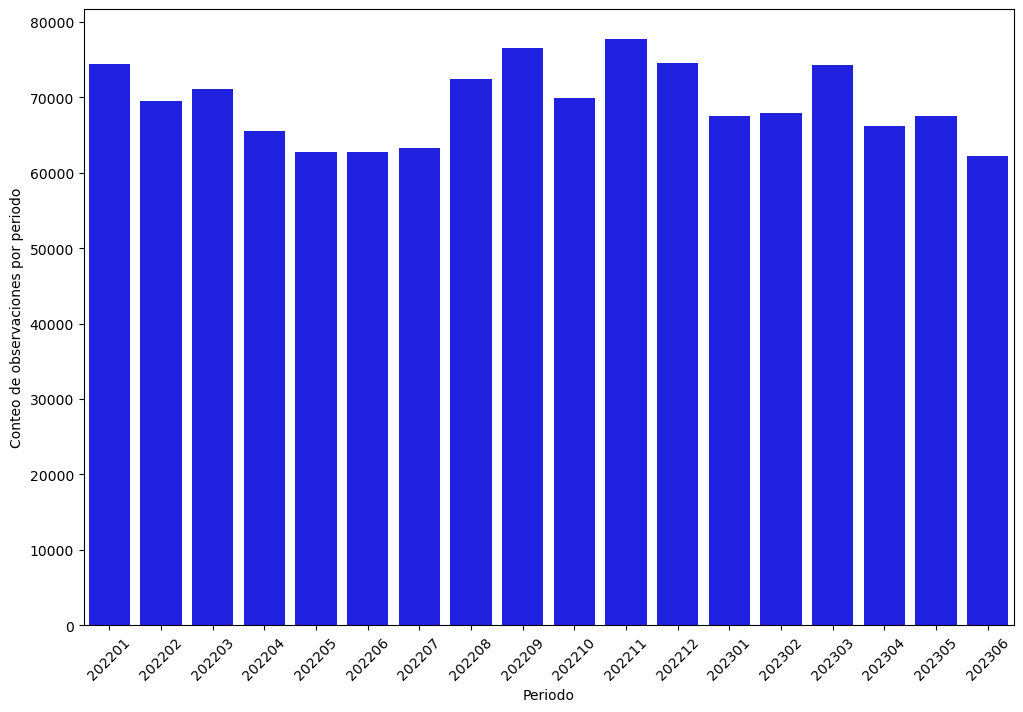

In [115]:
fig = plt.figure(figsize=(12,8))
seaborn.countplot(data=df_ventas_totales, x='yearmonth',
                color='blue')
plt.xticks(rotation=45)
plt.ylabel("Conteo de observaciones por periodo")
plt.xlabel("Periodo")
plt.ticklabel_format(style='plain', axis='y')

El barplot nos sirve para visualizar una determinada medida estadistica, la cual puede ser mean.

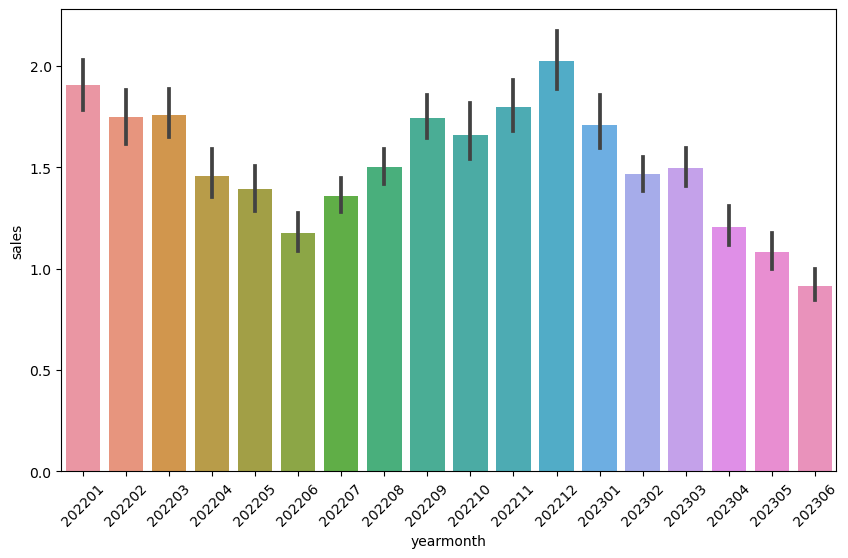

In [118]:
fig = plt.figure(figsize=(10,6))
seaborn.barplot(data=df_ventas_totales,
                y='sales', x='yearmonth',
                estimator=numpy.mean)
plt.xticks(rotation=45)
plt.show()

In [119]:
df_ventas_totales['sales'].describe().round(2)

count    1246467.00
mean           1.54
std           15.05
min          -18.00
25%            0.11
50%            0.26
75%            0.82
max         2769.77
Name: sales, dtype: float64

<Axes: xlabel='sales'>

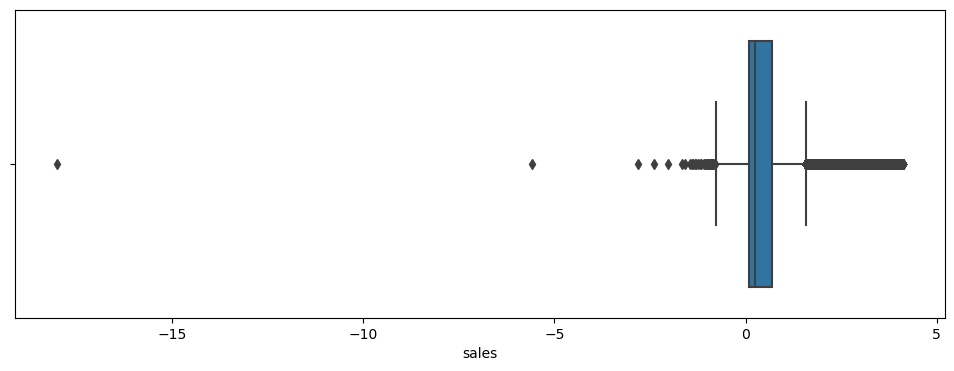

In [120]:
plt.figure(figsize=(12, 4))

seaborn.boxplot(x=df_ventas_totales[df_ventas_totales['sales'] < df_ventas_totales['sales'].quantile(0.95)]['sales'])

Queremos visualizar la distribucion de Sales por los diferentes meses del año, para eso debemos transformar la variable yearmonth en string, para que sea tomada como categorica, y no como numerica (por este motivo es importante chequear el tipo de datos con los que contamos).

In [122]:
df_ventas_2023 = df_ventas_totales[df_ventas_totales['yearmonth'] > 202212]
df_ventas_2023['yearmonth'] =  df_ventas_2023.yearmonth.apply(lambda x: str(x))

/var/folders/7p/g2x25rt54zj85__vsg7pyp3c0000gn/T/ipykernel_3205/250020174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_2023['yearmonth'] =  df_ventas_2023.yearmonth.apply(lambda x: str(x))


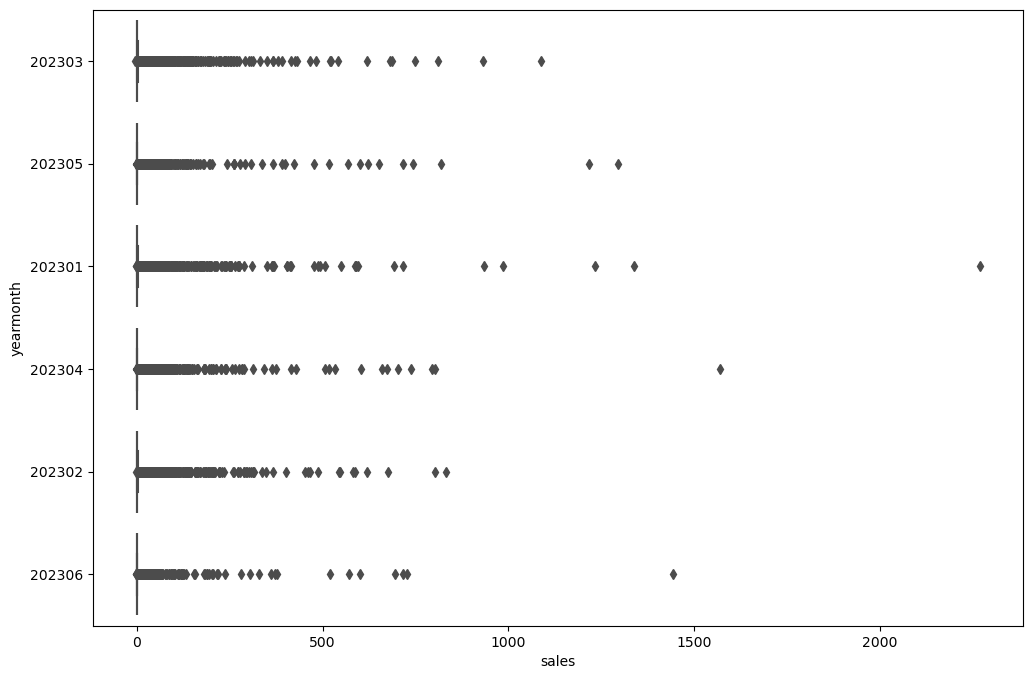

In [123]:
plt.figure(figsize=(12, 8))
seaborn.boxplot(data= df_ventas_2023,
                x='sales',
                y='yearmonth',
                color = 'orangered')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [124]:
df_ventas_2023.sales.describe()

count    405748.000000
mean          1.322371
std          12.744618
min          -5.584440
25%           0.085200
50%           0.240000
75%           0.720000
max        2269.963410
Name: sales, dtype: float64

In [125]:
df_ventas_2023.groupby('yearmonth').sales.describe()

,count,mean,std,min,25%,50%,75%,max
yearmonth,,,,,,,,
202301,67561.0,1.711594,16.942269,-1.29120,0.11352,0.31200,0.92700,2269.96341
202302,67887.0,1.467038,11.529431,-1.18260,0.11352,0.27318,0.84000,832.82772
202303,74251.0,1.499368,12.395076,-5.58444,0.09840,0.26460,0.83352,1088.21352
202304,66255.0,1.205120,12.434534,-1.07496,0.08505,0.23052,0.65028,1570.08259
202305,67569.0,1.082404,11.822171,-1.03000,0.05680,0.22704,0.61200,1293.73451
202306,62225.0,0.916157,10.112290,-2.80016,0.07568,0.20812,0.58260,1443.35789


Una forma de quitar los valores extremos es quedandonos con los valores que tienen una distribucion que representa a un determinado % de la muestra, por ejemplo 98%.

In [127]:
quantile = 0.98

In [128]:
df_ventas_2023.sales.quantile(quantile)

7.767599999999999

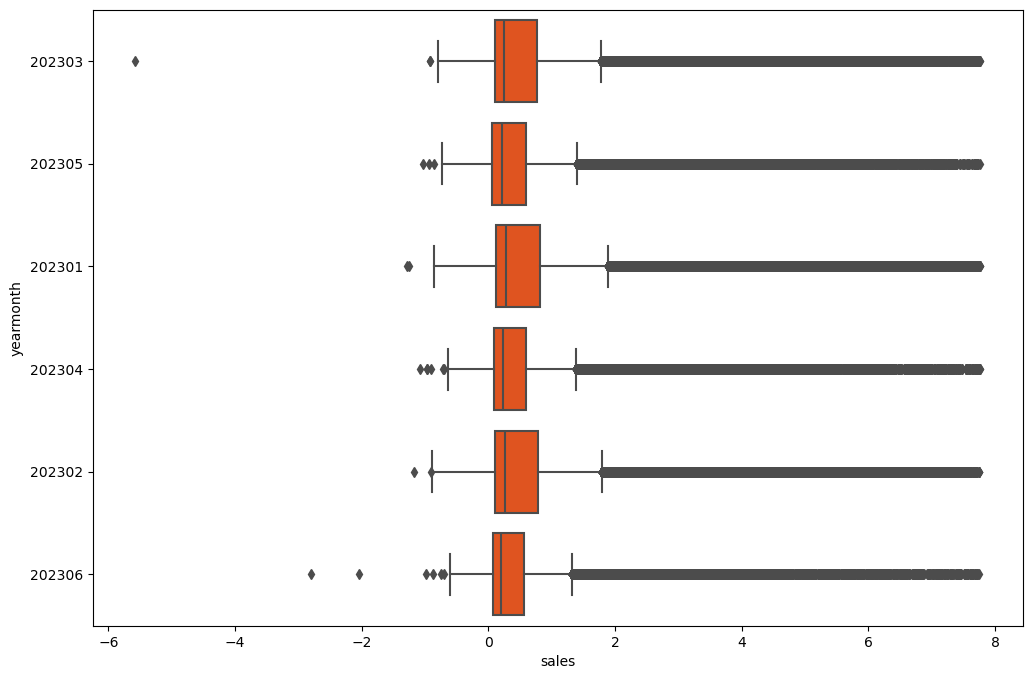

In [129]:
plt.figure(figsize=(12, 8))
seaborn.boxplot(data= df_ventas_2023[df_ventas_2023['sales'] < df_ventas_2023.sales.quantile(quantile)],
                x='sales',
                y='yearmonth',
                color = 'orangered')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [130]:
df_ventas_2023[df_ventas_2023['sales'] < df_ventas_2023.sales.quantile(quantile)].groupby('yearmonth').sales.describe()

,count,mean,std,min,25%,50%,75%,max
yearmonth,,,,,,,,
202301,65606.0,0.732270,1.143328,-1.29120,0.11352,0.28380,0.820560,7.76112
202302,66367.0,0.694313,1.097613,-1.18260,0.10406,0.25560,0.777325,7.75218
202303,72537.0,0.691968,1.109776,-5.58444,0.09840,0.25244,0.767400,7.75860
202304,65116.0,0.573758,0.970687,-1.07496,0.08160,0.22704,0.600000,7.76400
202305,66551.0,0.558400,0.959273,-1.03000,0.05676,0.21300,0.593520,7.76514
202306,61455.0,0.517078,0.895730,-2.80016,0.07098,0.19872,0.567600,7.75320


### Region 

In [136]:
df_ventas_totales.region.value_counts()

region
LITORAL            401672
GBA MINORISTAS     300049
CENTRAL            218562
PATAGONIA           99985
NOA                 96293
NEA                 73282
COSTA ATLANTICA     56624
Name: count, dtype: int64

### Brand 

In [146]:
df_ventas_totales.brand.value_counts()

brand
quilmes          277555
brahma           236113
stella_artois    190965
andes_origen     174040
budweiser        125480
corona           103581
patagonia         95049
otras             43684
Name: count, dtype: int64

In [148]:
df_ventas_totales.yearmonth.min()

202201

In [150]:
df_ventas_totales.groupby('cliente_id')[['yearmonth']].nunique().describe()

,yearmonth
count,28220.000000
mean,12.706449
std,5.738888
min,1.000000
25%,8.000000
50%,15.000000
75%,18.000000
max,18.000000


## Analisis para la creacion de muestra de clientes

Features para seleccionar la muestra de clientes:

- channel_id y region: las vamos a tomar como unicas, identificatorias del cliente.
- brand: conteo de marcas diferentes que compra el cliente
- yearmont: Frecuencia de compras, es decir buscamos clientes habituales o regulares. Compras en n meses del año calendario.
- Sales: monto de compras dividido por compras con promocion y sin promocion

In [154]:
df_ventas_totales['sales_without_coupons'] = df_ventas_totales['sales']

In [156]:
df_ventas_totales.loc[:2]

,cliente_id,channel_id,region,brand,sales,yearmonth,sales_with_coupons,participation_campein,sales_without_coupons
0,-928788236,1625004744,GBA MINORISTAS,corona,0.17040,202203,NaN,No,0.17040
1,-928788236,1625004744,GBA MINORISTAS,stella_artois,0.14190,202204,NaN,No,0.14190
2,-928788236,1625004744,GBA MINORISTAS,brahma,0.20514,202204,NaN,No,0.20514


In [158]:
df_ventas_totales['sales_without_coupons'] = df_ventas_totales.apply(
    lambda x: x['sales'] if x['participation_campein'] == 'No' else 0, axis=1
)

In [159]:
for index, row in df_ventas_tot_2.iterrows():
    if row['participation_campein'] == 'No':
        df_ventas_tot_2.loc[index, 'sales_without_coupons'] = row['sales']
    else:
        df_ventas_tot_2.loc[index, 'sales_without_coupons'] = 0

NameError: name 'df_ventas_tot_2' is not defined

In [ ]:
df_ventas_totales[df_ventas_totales['participation_campein'] == 'Si']

In [ ]:
df_ventas_totales.groupby('cliente_id').agg({'yearmonth' : 'nunique', 'brand' : 'nunique','sales':'sum'})